Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# Image Classification with a CNN

In the following we're going to train CNN's to predict digit images using the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database).  This [Wikipedia Page](https://en.wikipedia.org/wiki/MNIST_database) includes results from applying different kinds of ML algorithms to this problem. For more information, see [Yann LeCun's MNIST](http://yann.lecun.com/exdb/mnist/index.html) web page.

# Packages

In [38]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Markdown
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import linear_model
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_score, recall_score
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
%matplotlib inline


# Getting and Munging the Data

The data are already divided into train and test splits. 60,000 training, 10,000 test.

In [8]:
(X_train, y_train),(X_test, y_test) = mnist.load_data()

In [9]:
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(60000, 28, 28)

(60000,)

(10000, 28, 28)

(10000,)

Each X record is a 28 X 28 array. The elements are grayscale values ranging from 0 to 255.

In order speed training, we're going to use just one 10<sup>th</sup> of the data.

It's common practice to rescale the pixel values.  Here we'll rescale them to be in the range from 0 to 1.

In [10]:
X_train10=X_train[:6001,:]/255
y_train10=y_train[:6001]
X_test10=X_test[:6001,:]/255
y_test10=y_test[:6001]

## What Do the Pixel Data "Look" like?

Here's the 101<sup>th</sup> digit image in the training data, and the corresponding label:

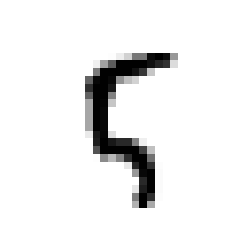

In [88]:
oneOone_image=X_train10[100].reshape(28,28)
plt.imshow(oneOone_image,cmap="binary")
plt.axis('off')
plt.show();

In [89]:
print("The corresponding label is ",y_train10[100])

The corresponding label is  5


In [90]:
np.random.seed(99)

# Fully Connected NN Classifier

In [3]:
keras.backend.clear_session()  # this resets
mod1=keras.models.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(200,activation='relu'),
    keras.layers.Dense(100,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
    ])

## Model Summary 

Note the number of parameters.

In [4]:
mod1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 178,110
Trainable params: 178,110
Non-trainable params: 0
_________________________________________________________________


## Initial Weights for a Layer

For example, for the 3<sup>rd</sup> layer.  The first array is the connection weights, and the second are for the biases.

In [5]:
mod1.layers[2].get_weights()

[array([[ 0.00147645,  0.14065756,  0.07329823, ..., -0.03142992,
         -0.02209172,  0.03629407],
        [ 0.06085843,  0.02788216,  0.10406539, ..., -0.12599929,
          0.09513302, -0.13601147],
        [-0.06026858,  0.0214259 , -0.08136399, ...,  0.09297666,
          0.03103964,  0.00906086],
        ...,
        [-0.11357392, -0.06161104,  0.03145878, ..., -0.13660033,
         -0.08003778, -0.0528652 ],
        [-0.0884479 ,  0.06783147, -0.0064802 , ...,  0.11409123,
          0.13330792,  0.00723165],
        [-0.08422725, -0.06671219, -0.11176863, ..., -0.08725052,
          0.05387481, -0.13847952]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

## Compiling Network

_Accuracy_, here, will be the classification accuracy.  "sparse_categorical_crossentropy" is used here because the target variable labels are single digits. "categorical_crossentropy" would be used instead if the labels were indicate by a 10 element 0/1 array, i.e. if they were "one hot" encoded.

In [6]:
mod1.compile(loss='sparse_categorical_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])

## Training

In [11]:
mod1Training=mod1.fit(X_train10, y_train10, epochs=50,
                     validation_data=(X_test10,y_test10),
                     verbose=0)


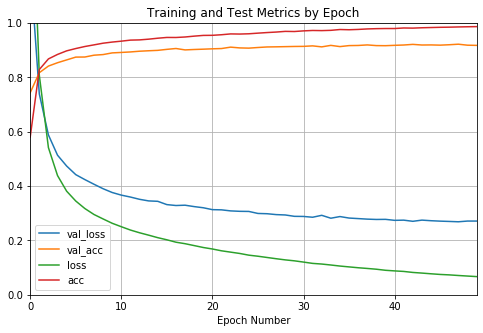

In [12]:
mod1historyDF=pd.DataFrame(mod1Training.history)
mod1historyDF.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Training and Test Metrics by Epoch")
plt.xlabel('Epoch Number')
plt.show();

In [13]:
mod1historyDF.iloc[mod1historyDF.val_acc.idxmax(),:]

val_loss    0.268667
val_acc     0.922013
loss        0.071022
acc         0.985502
Name: 47, dtype: float64

Recall that the curves for training should be shifted to the left.  

More epochs.

In [14]:
mod1Training2=mod1.fit(X_train10, y_train10, epochs=100,
                       initial_epoch=51,
                     validation_data=(X_test10,y_test10),
                     verbose=0)


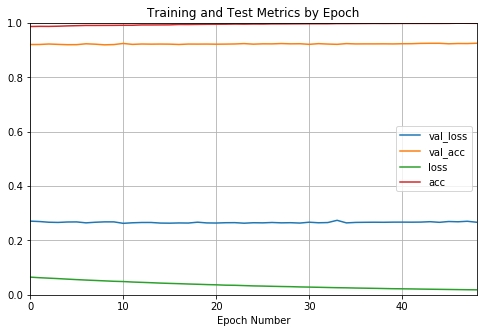

In [15]:
mod2historyDF=pd.DataFrame(mod1Training2.history)
mod2historyDF.shape

mod2historyDF.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Training and Test Metrics by Epoch")
plt.xlabel('Epoch Number')
plt.show();

## Network Evaluation and Predictions: Test Data

In [16]:
print("Test data loss, accuracy:")
mod1.evaluate(X_test10,y_test10)

Test data loss, accuracy:
6001/6001 [==============================] - 0s 49us/step


[0.2669764315783034, 0.9255124146174319]

In [17]:
y_pred=mod1.predict_classes(X_test10)
y_pred.shape
confusion_matrix(y_test10,y_pred)

(6001,)

array([[557,   0,   1,   0,   0,   0,   6,   1,   2,   1],
       [  0, 673,   4,   2,   0,   1,   4,   1,   1,   0],
       [  4,   3, 575,  12,   5,   0,   6,  10,   7,   3],
       [  4,   2,   8, 536,   0,  21,   2,  14,   6,   2],
       [  1,   0,   1,   0, 566,   0,   6,   4,   3,  18],
       [  8,   2,   0,  11,   4, 495,   9,   4,   9,   6],
       [  6,   3,   7,   0,  11,   8, 520,   3,   4,   0],
       [  0,   9,  19,   3,   6,   1,   0, 544,   1,  26],
       [  5,   4,   3,  16,   9,   6,   4,   7, 523,  10],
       [  3,   7,   1,   7,  22,   5,   1,   7,   4, 565]])

See [scikit.metrics Classification Report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) about the following.

In [18]:
print(classification_report(y_test10,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       568
           1       0.96      0.98      0.97       686
           2       0.93      0.92      0.92       625
           3       0.91      0.90      0.91       595
           4       0.91      0.94      0.93       599
           5       0.92      0.90      0.91       548
           6       0.93      0.93      0.93       562
           7       0.91      0.89      0.90       609
           8       0.93      0.89      0.91       587
           9       0.90      0.91      0.90       622

    accuracy                           0.93      6001
   macro avg       0.93      0.92      0.92      6001
weighted avg       0.93      0.93      0.93      6001



# UDU: See If you can Improve the Accuracy of the NN, Above.

Try different activation functions, increasing the number of neurons in the hidden layers. How about changing the learning rate, batch size, or other hyperparameters?

# UDU: Summarize Performance using Data Not Yet Used

So far we haven't yet  used all of the MNIST.  We only used the first 6,000 images. Use some of the remaining data to further assess the above model.  Use whichever version you think is the best.

# CNN

We'll now train some CNNs to predict the digit labels using multiple convolution and pooling layers.

Parameters to be set for a convulutional layer include:  
*the number of kernels, or "filters"  
* the kernel size  (the shape)  
* stride size
* "padding" type around the image edges  
* the type of activation function 


## CNN1

### Reshaping the X Data for A Convolution Layer

The X data needs to four dimensions:

* Number of samples.
* Image height.
* Image width.
* Channels (1 for grayscale pixels, 3 for RGB color).

Using keras, the _order_ of these dimensions depends on what the fit() function argument "data_format" is set to, "channels_first" or "channels_last." Somewhere in your environment there may be a keras.json file that provides the default as a value of "image_data_format."

In [46]:
X_train10r = X_train10.reshape(X_train10.shape[0], 28, 28, 1).astype('float32')
X_test10r = X_test10.reshape(X_test10.shape[0], 28, 28, 1).astype('float32')

### Layers:
    
* Conv - 32 filters that are 5 X 5, no strides, padding with zeros.
* Pooling - splits each image dimension in two.
* Flattening input; Dense layers expect 1D input
* Fully connected "Dense" layer with 64 neurons
* Softmax output layer 

In [80]:
 # del cnn1

In [47]:
keras.backend.clear_session()  # this resets
cnn1=keras.models.Sequential([
    keras.layers.Conv2D(32,(5,5),activation='relu',padding='same',
                        input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Flatten(),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])

In [48]:
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2592)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                82976     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 84,138
Trainable params: 84,138
Non-trainable params: 0
_________________________________________________________________


### Compile CNN1

In [49]:
cnn1.compile(loss='sparse_categorical_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])

### Train CNN1

In [50]:
cnn1Training=cnn1.fit(X_train10r, y_train10, epochs=50,
                     validation_data=(X_test10r,y_test10),
                     verbose=0)


### CNN1 Training History

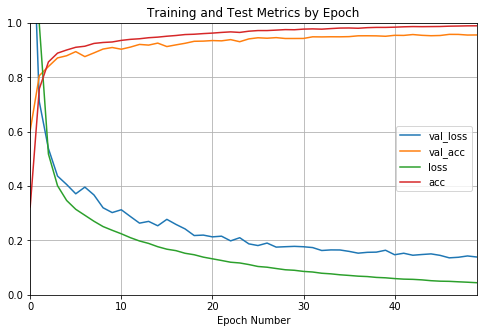

In [24]:
cnn1historyDF=pd.DataFrame(cnn1Training.history)
cnn1historyDF.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Training and Test Metrics by Epoch")
plt.xlabel('Epoch Number')
plt.show();

## CNN1 Evaluation

In [25]:
print("Test data loss, accuracy:")
cnn1.evaluate(X_test10r,y_test10)

Test data loss, accuracy:
6001/6001 [==============================] - 0s 67us/step


[0.13913371925032889, 0.9560073321113148]

In [26]:
cnn1PredClass=cnn1.predict_classes(X_test10r)

In [27]:
confusion_matrix(y_test10,cnn1PredClass)

array([[560,   0,   2,   0,   0,   0,   5,   0,   1,   0],
       [  0, 678,   3,   1,   0,   0,   3,   0,   1,   0],
       [  4,   3, 599,   4,   2,   0,   2,   4,   5,   2],
       [  1,   0,   8, 564,   0,  12,   0,   7,   1,   2],
       [  1,   1,   1,   0, 581,   0,   6,   3,   1,   5],
       [  4,   1,   1,   7,   1, 521,   3,   2,   5,   3],
       [  6,   3,   2,   0,   5,   2, 540,   0,   3,   1],
       [  0,   4,  14,   3,   4,   0,   0, 569,   2,  13],
       [ 10,   4,   7,  12,   7,   0,   1,   5, 533,   8],
       [  3,   7,   3,   1,  10,   1,   0,   5,   0, 592]])

In [28]:
print(classification_report(y_test10,cnn1PredClass))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       568
           1       0.97      0.99      0.98       686
           2       0.94      0.96      0.95       625
           3       0.95      0.95      0.95       595
           4       0.95      0.97      0.96       599
           5       0.97      0.95      0.96       548
           6       0.96      0.96      0.96       562
           7       0.96      0.93      0.95       609
           8       0.97      0.91      0.94       587
           9       0.95      0.95      0.95       622

    accuracy                           0.96      6001
   macro avg       0.96      0.96      0.96      6001
weighted avg       0.96      0.96      0.96      6001



# CNN2: A Deeper CNN

Let's add some additional Conv and Pooling Layers, an additional fully connected layer, and some dropout:

## CNN2 Network Specification

In [29]:
keras.backend.clear_session()  # this resets
cnn2=keras.models.Sequential([
    keras.layers.Conv2D(32,(5,5),activation='relu',padding='same',
                        input_shape=[28,28,1]),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Dropout(0.2),
    keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Flatten(),
    keras.layers.Dense(64,activation='relu'),
    keras.layers.Dense(32,activation='relu'),
    keras.layers.Dense(10,activation='softmax')
])

In [30]:
cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                36928     
__________

## Compiling CNN2

In [31]:
cnn2.compile(loss='sparse_categorical_crossentropy',
            optimizer='sgd',
            metrics=['accuracy'])

## Training CNN2

In [32]:
cnn2Training=cnn2.fit(X_train10r, y_train10, epochs=50,
                     validation_data=(X_test10r,y_test10),
                     verbose=0)


## CNN2 Training History

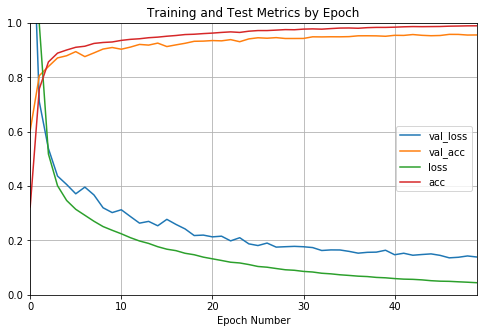

In [33]:
cnn2historyDF=pd.DataFrame(cnn2Training.history)
cnn1historyDF.plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.title("Training and Test Metrics by Epoch")
plt.xlabel('Epoch Number')
plt.show();

## CNN2 Evaluation

In [34]:
print("Test data loss, accuracy:")
cnn2.evaluate(X_test10r,y_test10)

Test data loss, accuracy:
6001/6001 [==============================] - 0s 64us/step


[0.08388416444584156, 0.973004499250125]

In [35]:
cnn2PredClass=cnn2.predict_classes(X_test10r)

In [36]:
confusion_matrix(y_test10,cnn1PredClass)

array([[560,   0,   2,   0,   0,   0,   5,   0,   1,   0],
       [  0, 678,   3,   1,   0,   0,   3,   0,   1,   0],
       [  4,   3, 599,   4,   2,   0,   2,   4,   5,   2],
       [  1,   0,   8, 564,   0,  12,   0,   7,   1,   2],
       [  1,   1,   1,   0, 581,   0,   6,   3,   1,   5],
       [  4,   1,   1,   7,   1, 521,   3,   2,   5,   3],
       [  6,   3,   2,   0,   5,   2, 540,   0,   3,   1],
       [  0,   4,  14,   3,   4,   0,   0, 569,   2,  13],
       [ 10,   4,   7,  12,   7,   0,   1,   5, 533,   8],
       [  3,   7,   3,   1,  10,   1,   0,   5,   0, 592]])

In [37]:
print(classification_report(y_test10,cnn2PredClass))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       568
           1       0.98      0.99      0.99       686
           2       0.99      0.95      0.97       625
           3       0.99      0.95      0.97       595
           4       0.97      0.98      0.98       599
           5       0.97      0.99      0.98       548
           6       0.99      0.98      0.98       562
           7       0.96      0.97      0.96       609
           8       0.94      0.98      0.96       587
           9       0.96      0.96      0.96       622

    accuracy                           0.97      6001
   macro avg       0.97      0.97      0.97      6001
weighted avg       0.97      0.97      0.97      6001



# Tensorboard Visualization

Tensorboard is a utility that allows "peaking into" network training.  There are a couple of ways to use it, and one is from in Jupyter.  This works, sometimes.  Here's an example use set-up.

In [39]:
# set up a dir to write logs into.

root_logdir=os.path.join(os.curdir,"ts_logs")

# A function that will create a new log directory for a training run

def create_log_dir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir,run_id)


In [40]:
# test the fcn

create_log_dir()

'./ts_logs/run_2019_07_25-14_39_16'

In [ ]:
# Try a run 

In [55]:
cnn1.reset_states() # initialize the cnn1 model
tensorboard_cb=keras.callbacks.TensorBoard(create_log_dir)
cnn1history=cnn1.fit(X_train10r, y_train10,epochs=50,
                    validation_data=(X_test10r,y_test10),
                     callbacks=[tensorboard_cb],
                    verbose=0)

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7fe27b3eb6a0>>
Traceback (most recent call last):
  File "/home/lynd/anaconda3/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/home/lynd/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.InvalidArgumentError: No such callable handle: 94146870231392


In [57]:
pd.DataFrame(cnn1history.history).describe()

,val_loss,val_acc,loss,acc
count,50.000000,50.000000,50.000000,50.000000
mean,0.142784,0.957997,0.008783,0.999320
std,0.002413,0.000974,0.002456,0.000413
min,0.137981,0.955007,0.005348,0.998334
25%,0.140954,0.957507,0.006751,0.999167
50%,0.142629,0.958174,0.008264,0.999417
75%,0.145027,0.958632,0.010783,0.999667
max,0.147284,0.959673,0.013916,1.000000


## Ways of Tensorboard

Two ways to do it.